<div class="jumbotron text-left"><b>
    
This tutorial describes how to sample a conditionned gaussian process.
<div>
    
Morgane Menz and Alexandre Thouvenot ONERA/DTIS/M2CI - June 2022
    
May 2023 version 2.0

# Conditioned Gaussian process

In the following notebook, we consider the function $f$ defined by:

$$f : \left\{ \begin{array}{c} [-10, 10] \rightarrow \mathbb{R} \\ x \mapsto x^2 \sin(x) \ \end{array} \right.$$

$f$ is approximated with a conditioned Gaussian process (GP) at points $-8.5$,  $-4.0$,  $-3.0$,  $-1.0$, $4.0$ and  $7.5$. 

In [17]:
# Maths / Kriging
import numpy as np
from smt.surrogate_models import KRG

# Plot
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

#to ignore warning message
import warnings
warnings.filterwarnings("ignore")

# Utils function to sample GP
from smt.utils.krg_sampling import sample_trajectory, gauss_legendre_grid, rectangular_grid, simpson_grid, eig_grid, sample_eigen

In [8]:
f = lambda x: x**2 * np.sin(x)

In [9]:
X_doe = np.array([-8.5, -4.0, -3.0, -1.0, 4.0, 7.5])
Y_doe = f(X_doe)

gp = KRG(theta0=[1e-2])
gp.set_training_values(X_doe, Y_doe)
gp._train()

In [10]:
x_min, x_max = -10, 10
n_plot = 1000
X_plot = np.linspace(x_min, x_max, n_plot)

gp_mean = gp._predict_values(X_plot.reshape(-1,1)).ravel()
gp_std = np.sqrt(gp._predict_variances(X_plot.reshape(-1,1)).ravel())

fig = go.Figure()
fig.add_trace(go.Scatter(x=X_plot, y=f(X_plot), mode='lines', name='f(x)'))
fig.add_trace(go.Scatter(x=X_plot, y=gp_mean, mode='lines', name='GP mean'))
fig.add_trace(go.Scatter(x=X_doe, y=Y_doe, mode='markers', name='DoE Point', marker=dict(size=10)))

fig.add_trace(go.Scatter(x=X_plot, y=gp_mean + 3 * gp_std, showlegend=False,
                         line=dict(color='gray', width=1, dash='dot')))

fig.add_trace(go.Scatter(x=X_plot, y=gp_mean - 3 * gp_std, name='Confidence Interval 99%',
                         line=dict(color='gray', width=1, dash='dot'),
                         fill='tonexty', fillcolor='rgba(255, 0, 0, 0.1)'))

fig.update_xaxes(title_text='x')
fig.update_yaxes(title_text='y')

fig.update_layout(width=1000, 
                  height=600, 
                  title={'text': "Function f and Gaussian Process approximation", 'x':0.45})

fig.show()

In [11]:
def plot_trajectories(X_plot, X_doe, Y_doe, X_traj, Y_traj, method_name):
    fig = go.Figure()
    n_traj = Y_traj.shape[1]
    traces = [go.Scatter(x=X_traj.ravel(), y=Y_traj[:,i], line=dict(width=1.5, dash='solid'),
                         name="Sample " + str(n_traj - i), showlegend=True) for i in range(n_traj)]

    fig.add_traces(traces)

    fig.add_trace(go.Scatter(x=X_plot, y=gp_mean + 3 * gp_std, showlegend=False,
                             line=dict(color='gray', width=1, dash='dot')))

    fig.add_trace(go.Scatter(x=X_plot, y=gp_mean - 3 * gp_std, name='Confidence Interval 99%',
                             line=dict(color='gray', width=1, dash='dot'),
                             fill='tonexty', fillcolor='rgba(255, 0, 0, 0.1)'))

    
    fig.add_trace(go.Scatter(x=X_plot, y=f(X_plot), mode='lines', marker_color='blue', name='f(x)'))
    fig.add_trace(go.Scatter(x=X_plot, y=gp_mean, mode='lines', marker_color='red', name='GP mean'))
    
    fig.add_trace(go.Scatter(x=X_doe, y=Y_doe, mode='markers', marker_color='lightseagreen', name='DoE Point'))

    fig.update_layout(title={'text': "Gaussian Process sampling with " + method_name, 'x':0.45})
    
    fig.update_xaxes(title_text='x')
    fig.update_yaxes(title_text='y')
    
    return fig 

## 1. GP sampling

There exists a natural way to sample a conditioned GP with the decomposition of the conditioned covariance matrix of the process. Given a set of points $\tilde{X}$, a conditioned GP $\mathcal{G}_n \sim GP(\mu_n(.), k_n(.,.))$ and $C_n(\tilde{X})$ the conditioned covariance matrix on $\tilde{X}$, a sample is given by:

$$\mathcal{G}_n(\tilde{X}) = \mu_n(\tilde{X}) + L_n(\tilde{X}) \xi$$

with $\xi \sim \mathcal{N}(0, I)$ and $C_n(\tilde{X}) = L_n(\tilde{X})L_n(\tilde{X})^T$. A such decomposition can be obtained with different methods.

### a. Cholesky Decomposition

The Cholesky decomposition yields an immediate decomposition of the conditioned covariance matrix. Nevertheless, this method is limited to small size evaluation sets to prevent ill-conditioned matrixes.

In [12]:
n_plot = 35
X_data = np.linspace(x_min, x_max, n_plot).reshape(-1, 1)

(35, 10)


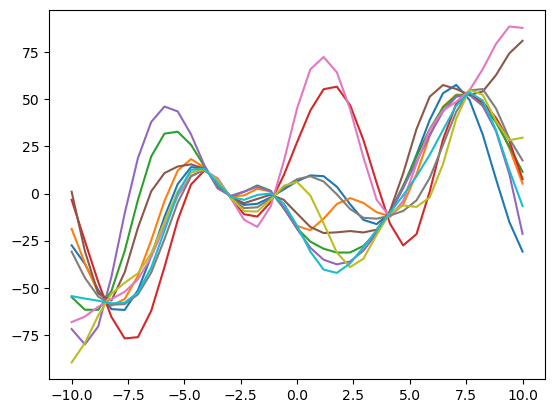

In [20]:
n_traj = 10
traj_chk = sample_trajectory(gp, X_data, n_traj, method="cholesky")
plt.plot(X_data, traj_chk)
print(traj_chk.shape)

In [14]:
fig = plot_trajectories(X_plot, X_doe, Y_doe, X_data, traj_chk, 'Cholesky decomposition')
fig.show()

### b. Eigendecomposition 

The second method is the eigendecoposition of the conditioned covariance matrix. This method has the same default that the Cholesky decomposition, but it is possible to floor the small negative eigenvalues to fix ill-conditioned matrixes and sample the conditioned GP on larger sets than the previous method. Nonetheless, compute eigendecomposition can be computationally expensive on huge set of points.

In [21]:
n_plot = 500
X_data = np.linspace(x_min, x_max, n_plot).reshape(-1, 1)

In [22]:
n_traj = 10
traj_eig = sample_trajectory(gp, X_data, n_traj, method="eigen")

In [23]:
fig = go.Figure()
fig = plot_trajectories(X_plot, X_doe, Y_doe, X_data, traj_eig, 'Eigendecomposition')
fig.show()

## 2. Karhunen–Loève decompostion

The Karhunen-Loève (KL) decomposition of a GP [1] is given by the following expression:

 $$G(x) = \mu(x) + \sum_{i=1}^{+\infty} \sqrt{\lambda_i} \varphi_i(x) \xi_i(\omega)$$
 
 where $\mu$ is the mean of the GP, $\xi_i$ are uncorrelated radom variables and $\lambda_i$, $\varphi_i$ are eigenvalues and eigenfunctions of the kernel.
 
To sample a GP with this formula, one keeps the $M$ larger eigenvalues to have an approximation of the GP given by $G(x) = \mu(x) + \sum_{i=1}^{M} \sqrt{\lambda_i} \varphi_i(x) \xi_i(\omega)$. In practice, a sampling strategy based on the KL decomposition of the conditioned kernel does not work very well.
 
The following decomposition method of a conditioned process [2, 3] is used with the KL representation to sample the GP:
 
- Construction of the GP $\mathcal{G}_n$ conditioned with the observations $\left( x_{doe}f(x_{doe}) \right)$, i.e. optimization of the hyperparameters $\theta$, $\sigma_z$ et $\beta$.
- Construction of a GP $\tilde{\mathcal{G}}(x)\sim GP \left(0,\sigma^2_Z r\left(x,x'\right)\right)$ using the optimal value of $\theta$ et $\sigma_z$ obtained previously.
  
- Simulation of a realization $\tilde{g}$ of $\tilde{\mathcal{G}}$ at points $(x,x_{doe})$ with KL representation
- Computation of $\tilde{\mu}(x)$ 
 \begin{equation}
\tilde{\mu}(x) = f(x)^T\tilde{\beta}+k(x)^TC^{-1} \left(\tilde{\mathcal{G}}(x_{doe})  - F\tilde{\beta} \right) 
\end{equation}
with $\tilde{\beta}=(F^TC^{-1}F)^{-1}F^TC^{-1}\tilde{g}(x_{doe})$

- Conditioning in order to obtain a trajectory of the conditioned GP $\mathcal{G}_n$ : $g(x) = \mu_n(x) - \tilde{\mu}(x) + \tilde{g}(x)$.

Here, 3 different quadrature methods are implemented to compute eigenvalues and eigenfunctions of the KL decomposition with the Nyström method [1].

[1] Betz, W., I. Papaioannou et D. Straub. 2014, «Numerical methods for the discretization of random fields by means of the Karhunen–Loève expansion», Computer Methods in Applied Mechanics and Engineering, vol. 271, doi: 10.1016/j.cma.2013.12. 010, p. 109–129, ISSN 0045-7825. URL http://www.sciencedirect.com/science/article/pii/S0045782513003502

[2] Villemonteix, J., E. Vazquez et E. Walter. 2009, «An informational approach to the global optimization of expensive-to-evaluate functions», Journal of Global Optimization, vol. 44, no 4, doi: 10.1007/s10898-008-9354-2, p. 509–534. URL https://hal-supelec.archives-ouvertes.fr/hal-00354262
or

[3] Le Gratiet, L., C. Cannamela et B. Iooss. 2014, «A Bayesian Approach for Global Sensitivity Analysis of (Multifidelity) Computer Codes», SIAM/ASA Journal on Uncertainty Quantification, vol. 2, no 1, doi: 10.1137/130926869, p. 336–363. URL https://epubs.siam.org/doi/abs/10.1137/130926869


In [24]:
# Number of integration points
n_points = 20
# Number of trajectories points
n_plot = 500
# Number of trajectories
n_traj = 10

# Integration domain bounds
bounds = np.array([[x_min], [x_max]])
# Set of trajectories points
X_data = np.linspace(x_min, x_max, n_plot).reshape(-1, 1)

In [25]:
x_grid_gl, weights_grid_gl = gauss_legendre_grid(bounds, n_points)
x_grid_rec, weights_grid_rec = rectangular_grid(bounds, n_points)
x_grid_sim, weights_grid_sim = simpson_grid(bounds, n_points)

In [26]:
eig_val_gl, eig_vec_gl, M_gl = eig_grid(gp, x_grid_gl, weights_grid_gl)
eig_val_rec, eig_vec_rec, M_rec = eig_grid(gp, x_grid_rec, weights_grid_rec)
eig_val_sim, eig_vec_sim, M_sim = eig_grid(gp, x_grid_sim, weights_grid_sim)

In [27]:
traj_gl = sample_eigen(gp, X_data, eig_val_gl, eig_vec_gl, x_grid_gl, weights_grid_gl, M_gl, n_traj)
traj_rec = sample_eigen(gp, X_data, eig_val_rec, eig_vec_rec, x_grid_rec, weights_grid_rec, M_rec, n_traj)
traj_sim = sample_eigen(gp, X_data, eig_val_sim, eig_vec_sim, x_grid_sim, weights_grid_sim, M_sim, n_traj)

In [28]:
fig = go.Figure()
fig = plot_trajectories(X_plot, X_doe, Y_doe, X_data, traj_gl, 'KL and Gauss-Legendre interpolation')
fig.show()

In [17]:
fig = go.Figure()
fig = plot_trajectories(X_plot, X_doe, Y_doe, X_data, traj_rec, 'KL and Rectangular grid interpolation')
fig.show()

In [18]:
fig = go.Figure()
fig = plot_trajectories(X_plot, X_doe, Y_doe, X_data, traj_sim, 'KL and Simpson interpolation')
fig.show()